In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay


# read file
file_path = "./DKA_patients.csv"
data = pd.read_csv(file_path)

# check the data
data.head()


,subject_id,hadm_id,glucose_level,ph_level,bicarbonate_level,ketone_level,gender,age,length_of_stay,cci,ama_discharge,insurance,num_procedures,related__comorbidity,readmission
0,10005817,28661809,261.3,7.290000,14.500000,82.50,M,66,16.000000,0,0,Medicare,6.0,0,0
1,10015860,24698912,269.5,7.280000,11.833333,64.00,M,53,0.625000,0,0,Other,8.0,0,0
2,10039708,28258130,266.0,7.211429,15.029412,64.25,F,46,16.166667,0,0,Other,21.0,0,0
3,10054716,25339060,261.2,7.210000,16.500000,192.00,M,61,6.041667,0,0,Other,7.0,0,0
4,10080961,24032231,559.0,7.260000,15.777778,32.50,F,40,4.708333,0,0,Other,16.0,0,0


### Data Wrangling

In [ ]:
# Check for NaN values in the dataset
nan_summary = data.isnull().sum()
print("Number of NaN values in each column:")
print(nan_summary)


Number of NaN values in each column:
subject_id               0
hadm_id                  0
glucose_level            0
ph_level                 0
bicarbonate_level        0
ketone_level             0
gender                   0
age                      0
length_of_stay           0
cci                      0
ama_discharge            0
insurance                0
num_procedures          40
related__comorbidity     0
readmission              0
dtype: int64


## GridSearch

In [ ]:
# Encode categorical features
data['gender'] = LabelEncoder().fit_transform(data['gender'])
data['insurance'] = LabelEncoder().fit_transform(data['insurance'])

# Define different NaN filling strategies
nan_fill_methods = {'mean': data.fillna(data.mean()), 'median': data.fillna(data.median())}

# Define different imbalance handling strategies
imbalance_methods = {
    'None': lambda X, y: (X, y),
    'SMOTE': lambda X, y: SMOTE().fit_resample(X, y),
    'Borderline-SMOTE': lambda X, y: BorderlineSMOTE().fit_resample(X, y),
    'Under-sampling': lambda X, y: RandomUnderSampler().fit_resample(X, y)
}

# Define the parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'n_estimators': [100, 200, 500],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [5, 10]
}

# Function to evaluate and print the model performance
def evaluate_model(X_train, X_test, y_train, y_test, best_params):
    # Train and evaluate with the best parameters
    model = LGBMClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_prob]

    # Calculate performance metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    return precision, recall, f1, roc_auc

# Loop through each NaN filling method and imbalance handling strategy
results = []

for fill_method, filled_data in nan_fill_methods.items():
    X = filled_data.drop(['readmission', 'subject_id', 'hadm_id'], axis=1)
    y = filled_data['readmission']

    # Apply variance threshold feature selection
    selector = VarianceThreshold(threshold=0.01)
    X_filtered = selector.fit_transform(X)

    for imbalance_name, imbalance_func in imbalance_methods.items():
        # Handle class imbalance
        X_resampled, y_resampled = imbalance_func(X_filtered, y)

        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

        # Initialize the LightGBM classifier
        lgb_estimator = LGBMClassifier(boosting_type='gbdt', objective='binary', metric='binary_logloss', random_state=42)

        # Set up Grid Search with Cross-Validation
        grid_search = GridSearchCV(estimator=lgb_estimator,
                                   param_grid=param_grid,
                                   scoring='roc_auc',
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=0)

        # Perform Grid Search to find the best hyperparameters
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        precision, recall, f1, roc_auc = evaluate_model(X_train, X_test, y_train, y_test, best_params)

        # Store the results
        results.append({
            'NaN Filling': fill_method,
            'Imbalance Handling': imbalance_name,
            'Best Parameters': best_params,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


c:\Users\22314\miniconda3\envs\CV\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 231, number of negative: 556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points 

c:\Users\22314\miniconda3\envs\CV\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 234, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data poi

In [ ]:
results_df

,NaN Filling,Imbalance Handling,Best Parameters,Precision,Recall,F1-Score,ROC-AUC
0,mean,None,"{'bagging_fraction': 0.8, 'bagging_freq': 5, '...",0.666667,0.327869,0.439560,0.684908
1,mean,SMOTE,"{'bagging_fraction': 0.9, 'bagging_freq': 10, ...",0.848921,0.842857,0.845878,0.921220
2,mean,Borderline-SMOTE,"{'bagging_fraction': 0.9, 'bagging_freq': 10, ...",0.828571,0.828571,0.828571,0.916058
3,mean,Under-sampling,"{'bagging_fraction': 0.8, 'bagging_freq': 10, ...",0.581818,0.551724,0.566372,0.633255
4,median,None,"{'bagging_fraction': 0.8, 'bagging_freq': 5, '...",0.666667,0.327869,0.439560,0.690935
5,median,SMOTE,"{'bagging_fraction': 0.8, 'bagging_freq': 5, '...",0.841379,0.871429,0.856140,0.919447
6,median,Borderline-SMOTE,"{'bagging_fraction': 0.8, 'bagging_freq': 5, '...",0.820690,0.850000,0.835088,0.901408
7,median,Under-sampling,"{'bagging_fraction': 0.8, 'bagging_freq': 10, ...",0.647059,0.568966,0.605505,0.659848


In [ ]:
results_df.to_csv('model_results.csv', index=False)

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Read the dataset
file_path = "DKA_patients.csv"
data = pd.read_csv(file_path)

# Data preprocessing: Encode categorical features
data['gender'] = LabelEncoder().fit_transform(data['gender'])
data['insurance'] = LabelEncoder().fit_transform(data['insurance'])

# Check for NaN values and fill with mean values
data = data.fillna(data.median())

# Split features and target
X = data.drop(['readmission', 'subject_id', 'hadm_id'], axis=1)  # Drop non-informative columns
y = data['readmission']

# Apply SMOTE for oversampling the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into train, validation, and test sets (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Set LightGBM parameters
params = {
    'objective': 'binary',  # Binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'metric': 'binary_logloss',  # Loss function for binary classification
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,  # Fraction of features to use in each boosting round
    'bagging_fraction': 0.8,  # Fraction of data to use in each boosting round
    'bagging_freq': 10,  # Perform bagging at every 5 iterations
    'verbose': -1  # Suppress output
}

# Train the LightGBM model using callbacks for early stopping
bst = lgb.train(
    params, 
    train_data, 
    num_boost_round=1000, 
    valid_sets=[valid_data],
    callbacks=[
        early_stopping(stopping_rounds=50),  # Early stopping after 50 rounds with no improvement
        log_evaluation(10)  # Log evaluation results every 10 iterations
    ]
)



Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.581041
[20]	valid_0's binary_logloss: 0.523142
[30]	valid_0's binary_logloss: 0.498198
[40]	valid_0's binary_logloss: 0.470835
[50]	valid_0's binary_logloss: 0.454729
[60]	valid_0's binary_logloss: 0.44531
[70]	valid_0's binary_logloss: 0.422977
[80]	valid_0's binary_logloss: 0.416429
[90]	valid_0's binary_logloss: 0.409704
[100]	valid_0's binary_logloss: 0.396959
[110]	valid_0's binary_logloss: 0.387407
[120]	valid_0's binary_logloss: 0.380671
[130]	valid_0's binary_logloss: 0.376034
[140]	valid_0's binary_logloss: 0.374394
[150]	valid_0's binary_logloss: 0.374691
[160]	valid_0's binary_logloss: 0.376189
[170]	valid_0's binary_logloss: 0.384588
[180]	valid_0's binary_logloss: 0.377968
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.372403


Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.595057
[20]	valid_0's binary_logloss: 0.548092
[30]	valid_0's binary_logloss: 0.515736
[40]	valid_0's binary_logloss: 0.488529
[50]	valid_0's binary_logloss: 0.467293
[60]	valid_0's binary_logloss: 0.450764
[70]	valid_0's binary_logloss: 0.44587
[80]	valid_0's binary_logloss: 0.448576
[90]	valid_0's binary_logloss: 0.452723
[100]	valid_0's binary_logloss: 0.451533
[110]	valid_0's binary_logloss: 0.445024
[120]	valid_0's binary_logloss: 0.43887
[130]	valid_0's binary_logloss: 0.444591
[140]	valid_0's binary_logloss: 0.443496
[150]	valid_0's binary_logloss: 0.44525
[160]	valid_0's binary_logloss: 0.446113
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.43828


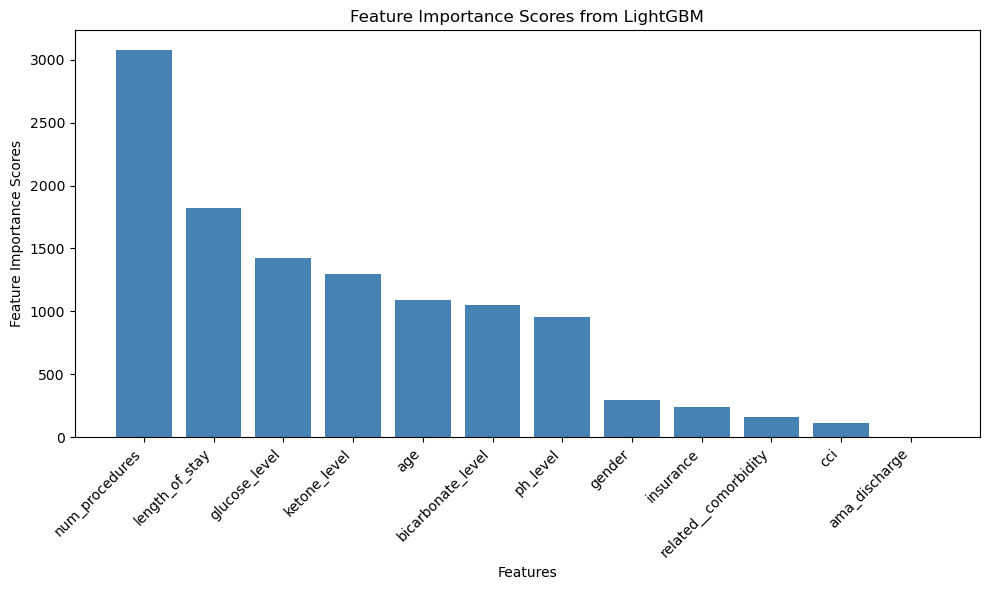

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Read the dataset
file_path = "DKA_patients.csv"
data = pd.read_csv(file_path)

# Data preprocessing: Encode categorical features
data['gender'] = LabelEncoder().fit_transform(data['gender'])
data['insurance'] = LabelEncoder().fit_transform(data['insurance'])

# Check for NaN values and fill with median values
data = data.fillna(data.median())

# Split features and target
X = data.drop(['readmission', 'subject_id', 'hadm_id'], axis=1)  # Drop non-informative columns
y = data['readmission']

# Apply SMOTE for oversampling the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into train, validation, and test sets (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Set LightGBM parameters
params = {
    'objective': 'binary',  # Binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'metric': 'binary_logloss',  # Loss function for binary classification
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,  # Fraction of features to use in each boosting round
    'bagging_fraction': 0.8,  # Fraction of data to use in each boosting round
    'bagging_freq': 10,  # Perform bagging every 10 iterations
    'verbose': -1  # Suppress output
}

# Train the LightGBM model using callbacks for early stopping
bst = lgb.train(
    params, 
    train_data, 
    num_boost_round=1000, 
    valid_sets=[valid_data],
    callbacks=[
        early_stopping(stopping_rounds=50),  # Early stopping after 50 rounds with no improvement
        log_evaluation(10)  # Log evaluation results every 10 iterations
    ]
)

# Feature importance
feature_importance = bst.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance 
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Feature Importance Scores")
plt.title("Feature Importance Scores from LightGBM")
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()



## Visulization

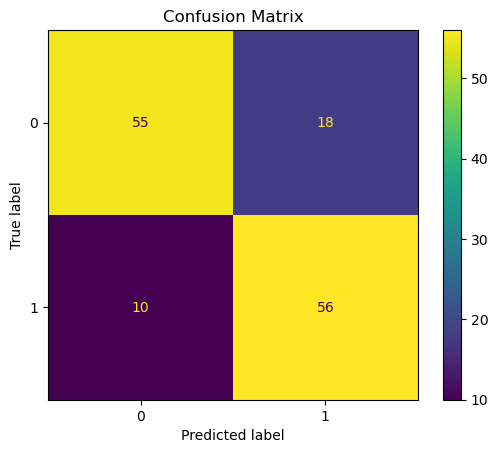

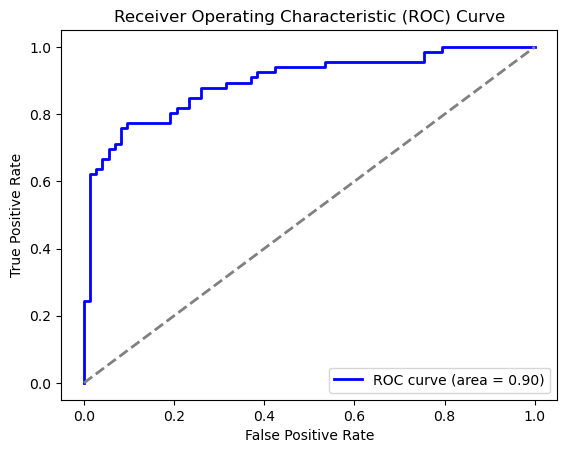

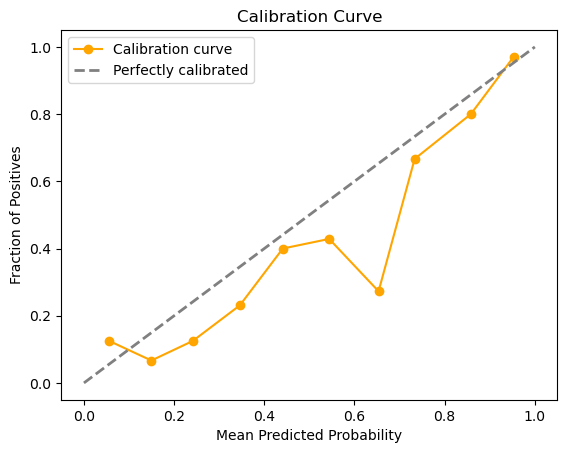

In [4]:
# Import necessary libraries for evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)  # Probability predictions
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_prob]  # Convert probabilities to binary predictions

# Calculate performance metrics
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Generate confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calibration Curve: Ensure probability predictions match with actual outcomes
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='orange', label='Calibration curve')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()